In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
%pip install -e . -q

[WinError 3] The system cannot find the path specified: '{HOME}/segment-anything-2'
c:\Users\guoyu\Documents\CompScience\cv-related\odorography


Cloning into 'segment-anything-2'...
c:\Users\guoyu\Documents\CompScience\cv-related\.venv\lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: file:///C:/Users/guoyu/Documents/CompScience/cv-related/odorography does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
%cd ./segment-anything-2
!python ./setup.py build_ext --inplace

c:\Users\guoyu\Documents\CompScience\cv-related\odorography\segment-anything-2


c:\Users\guoyu\Documents\CompScience\cv-related\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


CUDA_HOME environment variable is not set. Please set it to your CUDA install root.

Failed to build the SAM 2 CUDA extension due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; (see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).

running build_ext


In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

In [4]:
%pip install ultralytics

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 28.6 MB/s  0:00:00
   ---------------------------------------- 0.0/802.4 kB ? eta -:--:--
   ---------------------------------------- 802.4/802.4 kB 33.8 MB/s  0:00:00
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   --------- ------------------------------ 10.2/44.5 MB 49.1 MB/s eta 0:00:01
   ------------------ --------------------- 21.0/44.5 MB 51.0 MB/s eta 0:00:01
   ---------------------------- ----------- 31.7/44.5 MB 50.3 MB/s eta 0:00:01
   ------------------------------------- -- 41.7/44.5 MB 49.1 MB/s eta 0:00:01
   ---------------------------------------- 44.5/44.5 MB 44.9 MB/s  0:00:00

   ---------------------------------------- 0/5 [pyyaml]
   ---------------------------------------- 0/5 [pyyaml]
   ---------------------------------------- 0/5 [pyyaml]
   -------- ------------------------------- 1/5 [polars-runtime-32]
   ---


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from ultralytics import YOLO

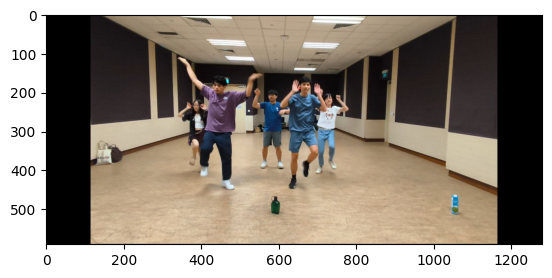

In [9]:
# sanity check on an image (use any you like from the mount, copy as path is easiest)
img_filepath = "assets/gira.jpg"
img = cv2.imread(img_filepath)
color_corrected = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(color_corrected)

In [10]:
print("The picture is of width x height")
print(img.shape[1], img.shape[0])

The picture is of width x height
1280 591


# Read a frame from a video
Try to get a video from drive and read the first frame

In [11]:
VIDEO_PATH = "/content/drive/MyDrive/JS2216/final_raise.mp4"
cap = cv2.VideoCapture(VIDEO_PATH)
ok, frame = cap.read()

assert ok, "Failed to Read"

AssertionError: Failed to Read

In [12]:
ultralytics_model = YOLO("yolo11s-pose.pt")

## Get some keypoints and map them onto the image


0: 320x640 5 persons, 153.8ms
Speed: 11.2ms preprocess, 153.8ms inference, 7.1ms postprocess per image at shape (1, 3, 320, 640)


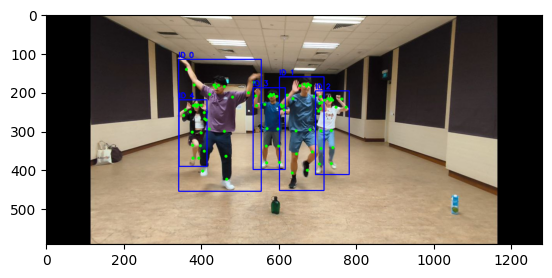

In [13]:
results = ultralytics_model(img)

KP_COLOR = (0, 255, 0)   # green
BOX_COLOR = (255, 0, 0)  # blue

for r in results:
  if r.keypoints is None:
    continue

  kps = r.keypoints.xy.cpu().numpy()     # (N, K, 2)
  conf = r.keypoints.conf.cpu().numpy()  # (N, K)
  boxes = r.boxes.xyxy.cpu().numpy() if r.boxes is not None else []

  # Draw per person
  for i, person_kps in enumerate(kps):

      # Draw bounding box
      if len(boxes) > i:
          x1, y1, x2, y2 = boxes[i].astype(int)
          cv2.rectangle(img, (x1, y1), (x2, y2), BOX_COLOR, 2)
          cv2.putText(img, f"ID {i}", (x1, y1 - 5),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.6, BOX_COLOR, 2)

      # Draw keypoints
      for j, (x, y) in enumerate(person_kps):
          if conf[i, j] < 0.3:   # confidence threshold
              continue
          cv2.circle(img, (int(x), int(y)), 4, KP_COLOR, -1)

color_corrected = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(color_corrected)

In [14]:
## Some images may have black padding, we should try to extract the actual region of the image
def extract_colored_region(img):
  # add dim for greyscale images
  if len(img.shape) == 2:
    img = np.expand_dims(img, axis=2)

  colored_areas = np.any(img > 0, axis=2) # checks the color channels to see if any are colored, returning a (H, W) array of booleans
  rows_w_color = np.any(colored_areas, axis=1) # checks rows if it has color, returning array of size (H,) of booleans
  cols_w_color = np.any(colored_areas, axis=0) # checks columns if it has color, return (W,)
  # print(cols_with_color) # array where columns with color have TRUE. False otherwise.

  # get bounding area
  row_indices = np.where(rows_w_color)[0]  # gets all indices with color (row)
  col_indices = np.where(cols_w_color)[0]
  min_row = row_indices[0]
  max_row = row_indices[-1]
  min_col = col_indices[0]
  max_col = col_indices[-1]

  actual_region = img[min_row:max_row+1, min_col:max_col+1] # inclusive slicing
  return actual_region


## Ground or Floor segmentation
### Classical CV pipeline (No Machine Learning)
- Transform frame into HSV space
- Extract Superpixels
- Obtain Edge Map from "S-channel" Image
- Construct a Region of Adjacency Graph from the combination of superpixels and edge map
- Do simple hierarchical merging
### Deep Learning
- Use FCN and RefineNet to generate a Mask
### Combining
- Unknown Post-Processing step with GLCM feature analysis


# HSV transform
- Get Saturation Channel
- Get Edge Map
- Get RAG

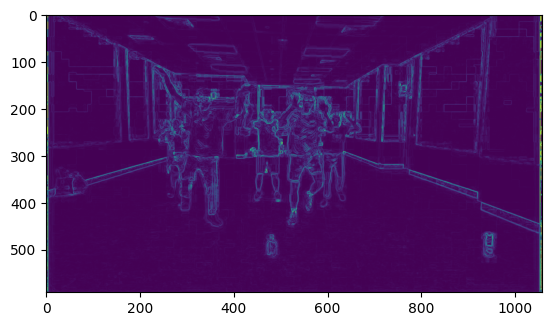

In [15]:
# Get S channel
img = cv2.imread(img_filepath)
img = extract_colored_region(img)
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
s_channel = hsv_img[:, :, 1] # channels: 0 -> H, 1 -> S 2 -> V

# Get edge_map (manual)
gx = cv2.Sobel(s_channel, cv2.CV_32F, 1, 0, ksize=3)
gy = cv2.Sobel(s_channel, cv2.CV_32F, 0, 1, ksize=3)

# Gradient magnitude
edge_map = np.sqrt(gx**2 + gy**2)

# Normalize for numerical stability (not thresholding!)
edge_map = cv2.normalize(edge_map, None, 0, 255, cv2.NORM_MINMAX)

plt.imshow(edge_map)

edges_for_cv2_visualization = cv2.convertScaleAbs(edge_map)
cv2.imshow("edge strengths", edges_for_cv2_visualization)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Superpixel
- get superpixels

In [20]:
%pip install scikit-image

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   --------- ------------------------------ 2.9/12.8 MB 13.9 MB/s eta 0:00:01
   --------------------------- ------------ 8.9/12.8 MB 22.1 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 22.9 MB/s  0:00:00

   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 [tifffile]
   ---------------------------------------- 0/4 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
## Use SLIC to get superpixels. SLIC is basically kmeans clustering with (HSV + XY) 5d vector
## with initial centers in 2S by 2S grid
from skimage.segmentation import slic

superpixel_img = slic(hsv_img, n_segments=200)


# Create Region Adjacency graph:
- Superpixels whose boundaries do NOT have high edge strengths should be favored during hierarchical merging.

In [69]:
from collections import defaultdict
import numpy as np

def build_edge_stats(labels, edge_map):
    """
    Compute boundary statistics between adjacent superpixels.

    This function scans the superpixel label image and detects boundaries
    where neighboring pixels belong to different superpixels. For each
    adjacent superpixel pair (i, j), it accumulates:

        - sum:   total edge strength along their shared boundary
        - count: number of boundary pixels (boundary length)

    These statistics allow later computation of a *perimeter-weighted*
    mean edge strength:
        mean = sum / count
    
    Use Case
    ---------
    Use this function to generate edge_stats required for the RAG class

    Parameters
    ----------
    labels : (H, W) ndarray of int
        Superpixel label image (e.g. output of SLIC).
    edge_map : (H, W) ndarray
        Edge strength image (e.g. Canny, Sobel magnitude).

    Returns
    -------
    stats : dict
        Mapping (a, b) -> {"sum": float, "count": int},
        where a < b are superpixel ids.
    """
    assert labels.shape == edge_map.shape

    stats = defaultdict(lambda: {"sum": 0.0, "count": 0})

    H, W = labels.shape
    for y in range(H - 1):
        for x in range(W - 1):
            s = labels[y, x]

            # right neighbor
            s_r = labels[y, x + 1]
            if s != s_r:
                a, b = sorted((s, s_r))
                stats[(a, b)]["sum"] += edge_map[y, x]
                stats[(a, b)]["count"] += 1

            # bottom neighbor
            s_d = labels[y + 1, x]
            if s != s_d:
                a, b = sorted((s, s_d))
                stats[(a, b)]["sum"] += edge_map[y, x]
                stats[(a, b)]["count"] += 1
    
    return stats
# create your stats
# edge_stats = build_edge_stats(superpixels, edge_map_manual)

In [70]:

class RAG:
  """
  Region Adjacency Graph (RAG) for agglomerative segmentation.

  The graph stores:
    - neighbours: region -> set of adjacent regions
    - edge_stats: (a, b) -> {"sum", "count"} boundary statistics
    - active:     set of currently active region ids
    - components: dict mapping merged components to their original constituting superpixels

  Pixel-level data is NOT stored here; all operations are performed
  using aggregated boundary statistics.

  The User is responsible for setting active regions and constructing an initial component tree.
  """
  def __init__(self, boundary_stats):
    """
    Initialize RAG from precomputed boundary statistics.

    rag.active and rag.components MUST be set by user outside of init

    Parameters
    ----------
    boundary_stats : dict
        Output of build_edge_stats(), mapping (a, b) -> {"sum", "count"}.
    """
    self.neighbours = defaultdict(set)
    self.edge_stats = dict(boundary_stats)
    self.active = set()
    self.components = {} # region_id -> set of original superpixels

    assert self.edge_stats is not None
    for (a, b), stats in self.edge_stats.items():
      self.add_edge(a, b, stats["sum"], stats["count"])

  def add_region(self, r):
    self.active.add(r)

  def add_edge(self, s1, s2, sum_, count_):
    a, b = sorted((s1, s2))
    self.neighbours[a].add(b)
    self.neighbours[b].add(a)
    self.edge_stats[(a, b)] = {"sum": sum_, "count": count_}

  def merge(self, s1, s2) -> int:
    """
    Merge two active regions into a new region.

    Boundary statistics are updated as follows:
      - For shared neighbors k:
          new_sum   = sum(s1,k) + sum(s2,k)
          new_count = count(s1,k) + count(s2,k)
      - For non-shared neighbors:
          inherit boundary stats unchanged.

    Parameters
    ----------
    s1, s2 : int
        Region ids to merge (must be active).

    Returns
    -------
    s_new : int
        Newly created region id.
    """
    # Invariants
    assert s1 in self.active and s2 in self.active
    assert s1 in self.components and s2 in self.components
    assert s1 != s2
    assert s2 in self.neighbours[s1]
    assert s1 in self.neighbours[s2]

    # since s1 and s2 are neighbours, there should be edge_stats
    key = tuple(sorted((s1, s2)))
    assert key in self.edge_stats

    # all components in s1 should really be disjoint from s2 before a merge
    assert self.components[s1].isdisjoint(self.components[s2])


    s_new = max(self.active) + 1
    self.active.add(s_new)

    neighbors = (self.neighbours[s1] | self.neighbours[s2]) - {s1, s2}

    for k in neighbors:
        key1 = tuple(sorted((s1, k)))
        key2 = tuple(sorted((s2, k)))

        if key1 in self.edge_stats and key2 in self.edge_stats:
            # shared neighbor → add stats
            sum_ = self.edge_stats[key1]["sum"] + self.edge_stats[key2]["sum"]
            count_ = self.edge_stats[key1]["count"] + self.edge_stats[key2]["count"]
        else:
            # single neighbor → inherit
            key = key1 if key1 in self.edge_stats else key2
            sum_ = self.edge_stats[key]["sum"]
            count_ = self.edge_stats[key]["count"]

        self.add_edge(s_new, k, sum_, count_)
    
    # new region should track what original superpixels construct it
    self.components[s_new] = self.components[s1] | self.components[s2]

    # cleanup
    foo = self.components.pop(s1)
    bar = self.components.pop(s2)

    self.active.remove(s1)
    self.active.remove(s2)
    return s_new


In [71]:
## Merging algorithm
import heapq

def build_pq(rag):
    """
    Build a priority queue of all active RAG edges.

    Each queue entry is:
        (mean_edge_strength, region_a, region_b)

    The queue is ordered so that the weakest boundaries
    are popped first.

    Parameters
    ----------
    rag : RAG

    Returns
    -------
    pq : list
        Heap-based priority queue.
    """
    pq = []
    seen = set()

    assert len(rag.active) > 0
    for r in rag.active:
      assert len(rag.neighbours[r]) > 0
      for n in rag.neighbours[r]:
          a, b = sorted((r, n))
          if (a, b) in seen:
            continue
          seen.add((a, b))

          stats = rag.edge_stats[(a, b)]
          mean_strength = stats["sum"] / stats["count"]
          heapq.heappush(pq, (mean_strength, a, b))

    return pq


def agglomerative_merge(rag, threshold):
  """
  Perform agglomerative hierarchical merging on a RAG.

  The algorithm repeatedly:
    1. Selects the adjacent region pair with the weakest boundary
    2. Merges them if the boundary strength is below `threshold`
    3. Updates the RAG and priority queue

  The RAG is mutated in-place.

  Parameters
  ----------
  rag : RAG
      Region Adjacency Graph.
  threshold : float (0, 255)
      Maximum allowed mean boundary strength for merging.
      Stronger edges are treated as true region boundaries.

  Returns
  -------
  None
  """
  pq = build_pq(rag)
  print(len(pq))

  # while !pq.empty()
  while pq: 
    w, s1, s2 = heapq.heappop(pq)

    # only consider active entries
    if s1 not in rag.active or s2 not in rag.active:
      continue

    if w > threshold:
      print("threshold reached")
      break # we shouldn't merge hard edges and should stop

    # merge in rag class
    s_new = rag.merge(s1, s2)

    # do update for heap here 
    for neighbour in rag.neighbours[s_new]:
      a, b = sorted((neighbour, s_new))
      stats = rag.edge_stats[(a, b)]
      w = stats["sum"] / stats["count"]
      heapq.heappush(pq, (w, a, b))


## Test pipeline
1. Prepare Edge Map and Superpixels (done)
2. Create Edge Stats
3. Create Region Adjacency Graph
4. Perform Merging until a set threshold strength

In [82]:
# 2. Create Edge Stats
bs = build_edge_stats(superpixel_img, edge_map)

# 3. Create RAG
rag = RAG(bs)

# self note: I initially wanted to create initial regions via set() then add all items in edge_stats (a, b) to get my unique regions.
# this is more complete.
initial_regions = np.unique(superpixel_img)
for r in initial_regions:
  rag.add_region(r)
  rag.components[r] = {r}

# 4. start Merging
agglomerative_merge(rag, 30)

362
threshold reached


# Visualizing it
1. Get all active regions
2. Get the regions constituent superpixels
3. outline it

In [83]:
# Getting all active regions
def build_final_labels(rag, superpixel_labels):
  """
  Map original superpixel labels to final merged region labels.
  """
  H, W = superpixel_labels.shape
  final_labels = np.zeros((H, W), dtype=np.int32)
  

  # For each pixel in the image, we map it to the correct region
  # substep 1, we only know which superpixel each pixel belongs to, thus we must do the
  # superpixel -> region mapping
  sp_to_region = {}
  for region, superpixels in rag.components.items():
    for sp in superpixels:
      sp_to_region[sp] = region # treat map like function now

  # substep 2, now we can map each pixel to region
  for y in range(H):
    for x in range(W):
      # get the superpixel a pixel belongs to
      sp = superpixel_labels[y, x]
      final_labels[y, x] = sp_to_region[sp]

  return final_labels
# 4. start Merging
foo = build_final_labels(rag, superpixel_img)
print(np.max(superpixel_img))
print(len(np.unique(foo)))

131
16


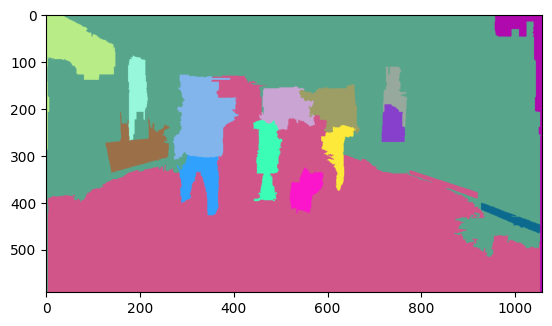

In [86]:
# color each region
def color_regions(final_labels):
    H, W = final_labels.shape
    out = np.zeros((H, W, 3), dtype=np.uint8)

    colors = {}
    for r in np.unique(final_labels):
        colors[r] = np.random.randint(0, 255, size=3)

    for y in range(H):
        for x in range(W):
            out[y, x] = colors[final_labels[y, x]]

    return out

color_viz = color_regions(foo)
plt.imshow(color_viz)